# 4. Event Selection - Preparing Input Data for the Neural Network

In the last notebook the exemplary neural network from notebooks 1. and 2. was implemented using Keras making our lives significantly easier by outsourcing the solutions of difficult code, like forward and backward propagation, to Keras functions, ultimately simplifying the code and letting us concentrate on the physics problem at hand.

In this notebook we already want to dive deeper into the real physics at the LHC, CMS specifically, and preprocess the data for the neural network. This primarily entails the selection of the relevant events from the whole data by imposing cuts on physical quantities and event characteristics.

## Di - Higgs

The goal of this notebook series is to make a neural network that is capable of identifying Di-Higgs events. Di-Higgs events are events where a Higgs boson splits into two Higgs bosons via the 3-point self interaction. From the Higgs theory it is evident that this process is very rare and incredibly difficult to come by and identify. The primary Higgs can be produced in various ways, the most prevalent one being gluon-gluon-fusion accounting for about 87% of the  production. The two Higgs in the final state then continue to decay in different ways. One of the ways to identify a Di-Higgs event is to look for a $b \bar{b} + l$ signiture, where the $b\bar{b}$ jets come from one Higgs and the lepton originates from the other. For the signiture only muons are looked at (in this notebook at least).

This process of course has it's fair share of background like the production of top quarks, production of W bosons associated with jets and many others due to various QCD interactions.

In this notebook real experimental data will not be used, instead, Monte Carlo simulated data for the separate signal and background processes will be used.

## Data opening and preparation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# locate directory
files = os.listdir('/nfs/dust/cms/user/matsch/for_Artak/GluGluToHHTobbVV/')
print(files)

['C6092B8E-34AB-324C-97BC-2FE673889E32.root']


Once the data directories are located the individual files that are within are opened using *uproot*. Uproot is a python package that is capable of opening and manipulating *ROOT* format files. These are files structured in a similar way to UNIX file directories where objects can be stored in an arbitrary substructure in a machine independent fashion. You can read more about uproot in the [uproot docs](https://uproot.readthedocs.io/en/latest/basic.html).

Because the data regarding particular process is available over a series of "bite-sized" files, it is quite handy to store the opened files in a dictionary where each entry refers to a different process and the inidivdual files can be accessed via the key associated with the process.

In [3]:
import vector
import uproot
import awkward as ak

# register awkward to be able to use 4-vector behaviour 
vector.register_awkward()

# specify directory paths
p_signal = '/nfs/dust/cms/user/matsch/for_Artak/GluGluToHHTobbVV/'
p_bgr_tt = '/nfs/dust/cms/user/matsch/for_Artak/TTToSemiLeptonic/'
p_bgr_st = '/nfs/dust/cms/user/matsch/for_Artak/ST_tW_top_5f_inclusive/'
p_bgr_Wj = '/nfs/dust/cms/user/matsch/for_Artak/WJetsToLNu/'

# dictionary containing files for signal and background processes 
files_dict = {'signal': p_signal, 'bgr_tt': p_bgr_tt, 'bgr_st': p_bgr_st, 'bgr_Wj': p_bgr_Wj}

# specify individual file paths and open them with uproot
# when opening a file, different types of data are written in a dictionary
for path in files_dict:
    files = os.listdir(files_dict[path])
    
    for count, file in enumerate(files):
        files[count] = uproot.open(files_dict[path] + file)
        
    files_dict[path] = files
    
# read out trees
tree_dict = {}

# particular data categories can be accessed with "key" "value" method by using sqare brackets
# event trees are extracted from the files
for path in files_dict:
    path_files = files_dict[path]
    
    for count, file in enumerate(path_files):
        path_files[count] = file["Events"]
    
    tree_dict[path] = path_files
    
print(tree_dict)

{'signal': [<TTree 'Events' (1628 branches) at 0x2b5a661c0130>], 'bgr_tt': [<TTree 'Events' (1628 branches) at 0x2b5a6619ff70>], 'bgr_st': [<TTree 'Events' (1628 branches) at 0x2b5a6619ffd0>], 'bgr_Wj': [<TTree 'Events' (1628 branches) at 0x2b5bd5ea5330>, <TTree 'Events' (1628 branches) at 0x2b5a6619feb0>, <TTree 'Events' (1628 branches) at 0x2b5a661c0190>]}


## Directly accessing fields via filters

Following the opening of the files, the necessary fields for the selection of events have to be specified and accessed via filters. This is done using a python package called *awkward*. It's great for nested variable-sized data and performs operations very quickly. Learn more about awkward in the [awkward docs](https://awkward-array.readthedocs.io/en/latest/). The events from the different files are converted into awkward arrays all the while only the specified fields are selected. This is done such that muons and jets, the signature we are actively looking for, are stored separately in a list for all the files.

The fields that are relevant to this little analysis are:
* $p_T$ [GeV]
* $\eta$
* $\phi$ [rad]
* mass [GeV]
* charge

For jets there's additionally a field called "btagDeepB" which can be understood as the probability of a certain jet to be identified as a $b$-jet.

In [4]:
# necessary fields to be extracted
fields = ["pt", "eta", "phi", "mass", "charge", "btagDeepB"]

# only muons and jets are selected since they make up the desired signiture
muons_dict = {}
jets_dict = {}

# for each file the specified fields are selected for muons and jets only
for path in tree_dict:
    trees = tree_dict[path]
    
    # temporary lists to store awkward arrays
    muons_temp = []
    jets_temp = []
    
    for tree in trees:
        muons_temp.append(tree.arrays(filter_name = ["Muon_" + f for f in fields]))
        jets_temp.append(tree.arrays(filter_name = ["Jet_" + f for f in fields]))
    
    muons_dict[path] = muons_temp
    jets_dict[path] = jets_temp

# concatenate all the same events into a single dictionary entry as if it originated from a single file
for path in muons_dict:
    muons_dict[path] = ak.concatenate(muons_dict[path], axis = 0)
    
for path in jets_dict:
    jets_dict[path] = ak.concatenate(jets_dict[path], axis = 0)

The goal is to combine all "particle arrays" to a single "events array" where in the subcategories the attributes are no more referenced as "{Object}\_{field}" but simply as the "{field}" .This is done using the function `replace`. Additionally, the argument `with_name = 'Momentum4D'` is given, which identifies the elements of the arrays as physical 4-vectors which in turn allows them to be used in physically relevant operations like the calculation of the invariant mass of the objects. With `zip` the new fields are combined in a new array. And finally, the two object arrays, muons and jets are zipped to construct the event array. The different subcategories can still be accessed by using the particle type and physical quantities as attributes.

In [5]:
# switch naming of fields from "{Object}_{field}" to "{field}"
events_dict = {}

for i in muons_dict:
    
    muons_dict[i] = ak.zip({key.replace("Muon_",""):muons_dict[i][key] for key in muons_dict[i].fields}, with_name = "Momentum4D")
    jets_dict[i] = ak.zip({key.replace("Jet_",""):jets_dict[i][key] for key in jets_dict[i].fields}, with_name = "Momentum4D")

    # combine fields into a single awkward "events array" via ak.zip
    events_dict[i] = ak.zip({"Muon": muons_dict[i], "Jet": jets_dict[i]}, depth_limit=1)
    
# the lists corresponding to the arrays contain multiple numbers

print(f"Event fields:      {events_dict['signal'].fields} \n")

print(f"Muon fields:       {events_dict['signal'].Muon.fields}")
print(f"Muon object class: {type(events_dict['signal'].Muon)} \n")

print(f"Jet fields:        {events_dict['signal'].Jet.fields}")
print(f"Jet object class:  {type(events_dict['signal'].Jet)} \n")

Event fields:      ['Muon', 'Jet'] 

Muon fields:       ['eta', 'mass', 'phi', 'pt', 'charge']
Muon object class: <class 'vector._backends.awkward_.MomentumArray4D'> 

Jet fields:        ['btagDeepB', 'eta', 'mass', 'phi', 'pt']
Jet object class:  <class 'vector._backends.awkward_.MomentumArray4D'> 



## Event selection

We hope to examine the final states of the events and search for a signature that might be reminiscent of the decay of two Higgs bosons which might indicate a Di-Higgs event. The selection is performed by making various cuts on the data. Namely:

Muons:
* exactly one muon
* minimum $p_T$ of 25 GeV
* maximum $|\eta|$ of 2.5

Jets:
* at least 4 jets
* two of which must be $b$-jets
* minimum $p_T$ of 25 GeV
* maximum $|\eta|$ of 2.5

The btagDeepB is not a binary response and can attain the continuous range of values betweeen 0 and 1. Thus "determining" if a jet is identified as a $b$-jet depends on the *workingpoint* with which a $b$-jet is "defined".

The cuts on $p_T$ and $\eta$ are cuts on objects whereas cuts on the number of objects are cuts on the events. They are performed in a particular order: object cuts first, event cuts second. This is to guarantee that only those events are selected which feature the desired signature.

In [6]:
# the most common workingpoints for b-jet identification
btag_loose = 0.1208
btag_medium = 0.4168
btag_tight = 0.7665

The cuts are performed by applying masks on the arrays, selecting only those objects / events which satisfy the signature. Separate functions have been written to return the object and event masks, with unique event masks for leptons and jets respectively, as different numbers of objects are required for the two. Exclusively for the jets, another function has been defined that solely returns the $b$-tagging mask. Both the masks as well as the cut requirements on the various physical quantities are exemplarily hard-coded in this notebook, but you are very much welcome to make improvements to it!

The way it is implemented down below, applying the mask overwrites the event data such that the remaining data is the one of interest. Notice how the event masks are defined and applied immediately after i.e before defining the following event masks. This is due to the fact that masks have to be defined for the exact arrays they are supposed to act on. If an event mask is applied to an array which the mask was not defined on, an error will be raised. This is not an issue for object masks, since the arrays stay the "same" in terms of still featuring the event (eventhough certain objects might have been cut).

In [7]:
# masking function
def mask_events(event_data):   

    # muon properties
    m_eta = 2.5
    m_pt = 25
    m_n = 1
    
    # jet properties
    j_eta = 2.5
    j_pt = 25
    j_n = 4
    j_btag = 2
    
    # mask for object based cuts on the full event data
       
    m_mask_obj = (np.abs(event_data['Muon'].eta) < m_eta) & (event_data['Muon'].pt > m_pt)
    j_mask_obj = (np.abs(event_data['Jet'].eta) < j_eta) & (event_data['Jet'].pt > j_pt)
    
    # apply object based cuts on full event data and overwrite original data
    event_data['Muon'] = event_data['Muon'][m_mask_obj]
    event_data['Jet'] = event_data['Jet'][j_mask_obj]
            
    # mask for and apply event based cut on object-masked data    
    m_mask_n = (ak.num(event_data['Muon']) == m_n)
    event_data = event_data[m_mask_n]
    
    j_mask_n = (ak.num(event_data['Jet']) >= j_n)
    event_data = event_data[j_mask_n]
    
    j_mask_b = (ak.num(event_data['Jet'][event_data['Jet'].btagDeepB > btag_tight]) == j_btag)
    event_data = event_data[j_mask_b]

    # number of events after performing cuts
    events_final = ak.num(event_data)

    return event_data #events_final, len(events_final)
    

In [8]:
# finally apply selection on data
selection_dict = {}

for events in events_dict:
    selection_dict[events] = mask_events(events_dict[events])

## Plot selection in histograms

The "physics" of a process is given by the cross section associated with it. Statements on the cross section can be made by measuring the integrated luminosity, which is solely given by the experiment, and detecting the number of events:

### $(1) \,\,\, N = L_{int} \cdot \sigma$

We now wish to plot the selection of the signal data and background data in the same plot to compare the number of events in a histogram. For the histogram to make physical sense, the luminosities of the processes have to be the same such that the number of events for signal and background processes are given by the proportional differences between the cross sections. The cross sections for the signal and background processes are all very well known values from theoretical calculations and experimental results. The situation for the luminosities, though, is very different. Since the data that is being used for this notebook is from Monte Carlo simulations the "effective luminosities" with which the events are generated, can be arbitrarily high. Naturally, for comparable file sizes, the effective luminosities are very different for the processes that are being considered here. The different contributions to the histograms thus have to be weighted for the number of events of the processes to be in correct proportions.

First, the effective luminosities are calculated using formula $(1)$. It is important to note, that for $N$ the number of all events in the data has to be used not only the selected events. This is of course because all events in the files are simulated as e.g. Di-Higgs signals. The selection only contains the Di-Higgs events which match the signature we are looking for. The same is true for the background. The weights are calculated as the fractions of the effective luminosities and a "real" luminosity which is supposed to immitate a certain experiment. Since it only specifies the scale for the number of events and has no influence on the relative differences it is exemplarily set to 1.

In [9]:
# cross sections and weights: N = L * sigma

# cross sections in pb
sig_HH = 3.4491e-3
sig_tt = 364.33
sig_st = 35.85
sig_Wj = 3130

# number of generated events prior to selection
N_HH = len(ak.num(events_dict['signal']))
N_tt = len(ak.num(events_dict['bgr_tt']))
N_st = len(ak.num(events_dict['bgr_st']))
N_Wj = len(ak.num(events_dict['bgr_Wj']))

# "real" luminosity in pb (this value is not actually correct, it's just to get the point across)
L = 1

# Monte Carlo luminosities
L_HH = N_HH / sig_HH
L_tt = N_tt / sig_tt
L_st = N_st / sig_st
L_Wj = N_Wj / sig_Wj

# weights relative to signal luminosity
w_HH = L / L_HH
w_tt = L / L_tt
w_st = L / L_st
w_Wj = L / L_Wj

weights = {'signal': w_HH, 'bgr_tt': w_tt, 'bgr_st': w_st, 'bgr_Wj': w_Wj}

print(weights)

{'signal': 1.4027574426549536e-08, 'bgr_tt': 0.0002815533230293663, 'bgr_st': 5.584112149532711e-05, 'bgr_Wj': 0.002219050799248217}


Before the histograms can be plottet they have to be constructed first. For this the convenient package *hist* is used. Histograms are made for muons and jets separately, each with the subcategories of signal and the various backgrounds that are being considered. New histograms are made by calling `hist.Hist.new`. The physical quantities in respect to which the histogram can be plotted are added by simply specifying the axis type (type of binning) and the name. The *string category* axis makes a histogram based on the string attributes specified. The *regular* axis makes a histogram with a set number of equally sized bins ranging from a starting value to an ending value. The *variable* axis makes a histogram with manually set bins which do not have to have the same size. There are also other axis types but they won't be used here. All of these axes can be embedded into a single "multidimensional" hist object. Read more about hist in the [hist docs](https://hist.readthedocs.io/en/latest/).

The histograms also have to be filled with data. This is done with the `fill` function where it is important that the axis names correspond to the variables that are being filled and also that the data to be filled is flattened. Otherwise an error is raised. Only the leading jets (jets with the highest $p_T$) are filled.

In [10]:
import hist

# files list in order
files_list = ['signal', 'bgr_Wj', 'bgr_st', 'bgr_tt', ]

# object list
objects = {"Muon": files_list, "Jet": files_list}

object_hist_dict = {}

for i in objects:

    # construct histogram for muons and jets displaying the distribution in pt, eta and phi
    object_hist_dict[i] = (
        hist.Hist.new
        .StrCat(files_list, name = "process", label = "process") # histrogramm with 4 separate categories
        .Reg(20, 30, 200, name = "pt", label = f"{i} " + "$p_{T}$ [GeV]") # histogram with regular sized bins (20 bins, starting pt 30 ending pt 100)
        .Var(np.linspace(-2.5, 2.5, 20), name = "eta", label = f"{i} " + "$\eta$") # histogram with variable sized bins (specified bins [])
        .Reg(20, -np.pi, np.pi, name = "phi", label = f"{i} " + "$\\phi$")
        .Double()
    ) 

    for sub_cat in files_list:
    
        # fill histograms with leading jets
        object_hist_dict[i].fill(
            process = sub_cat,
            pt = selection_dict[sub_cat][i].pt[:, 0],
            eta = selection_dict[sub_cat][i].eta[:, 0],
            phi = selection_dict[sub_cat][i].phi[:, 0],
            weight = weights[sub_cat]
        )

In [11]:
# construct sub histograms to be plotted 
selection_hist = {"m_pt":  object_hist_dict['Muon'][{"eta": sum, "phi": sum}], # signal, background vs pt
                  "m_eta": object_hist_dict['Muon'][{"pt": sum, "phi": sum}],  # signal, background vs eta
                  "m_phi": object_hist_dict['Muon'][{"pt": sum, "eta": sum}],  # signal, background vs phi
                  "j_pt":  object_hist_dict['Jet'][{"eta": sum, "phi": sum}],  # signal, background vs pt
                  "j_eta": object_hist_dict['Jet'][{"pt": sum, "phi": sum}],   # signal, background vs eta
                  "j_phi": object_hist_dict['Jet'][{"pt": sum, "eta": sum}],}  # signal, background vs phi

From the two histograms that have been made and filled for the muons and jets the number of events in dependance of $p_T$, $\eta$ and $\phi$ can be plotted.

In [12]:
# plots are made using the mplhelp style
import mplhep

def plotting(histogram, subplot_shape, fig_size, p, setting):
    
    if setting == 'density':
        histtype = 'step'
        stack = False
        alpha = 1
        density = True
    else:
        histtype = 'fill'
        stack = True
        alpha = 0.75
        density = False

    # cms style
    plt.style.use(mplhep.style.CMS)
        
    fig = plt.figure(figsize = fig_size, facecolor = 'white', dpi = 40)

    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    # a splash of color
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["lawngreen", "red", "dodgerblue"])
    # plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["seagreen", "peachpuff", "cadetblue"])
    # plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["thistle", "mediumorchid", "indigo"])
    # plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["limegreen", "yellow", "red"])

    # opacity of the plots
    a = 0.75

    # make axes
    axes = np.array([fig.add_subplot(subplot_shape[0], subplot_shape[1], i) for i in range(1, len(histogram) + 1)])

    # permutate axes
    axes = axes[p]

    for count, sub_hist in enumerate(histogram):

        # plot of background sub histogram
        histogram[sub_hist][{"process": ['bgr_Wj', 'bgr_st', 'bgr_tt',]}].plot1d(
            ax = axes[count],
            overlay = "process",
            histtype = histtype,
            stack = stack,
            density = density,
            alpha = alpha,
            # edgecolor = None,
        )

        # plot of signal sub histogram
        histogram[sub_hist][{"process": ['signal']}].plot1d(
            ax = axes[count],
            overlay = "process",
            histtype = "step",
            stack = False,
            alpha = 1,
            density = density,
            edgecolor = (0, 0, 0, 0),
        )

        axes[count].semilogy()
        axes[count].set_ylabel("Events from selection")
        mplhep.cms.label(ax = axes[count], label = "Private Work")
        axes[count].legend()

    plt.show()

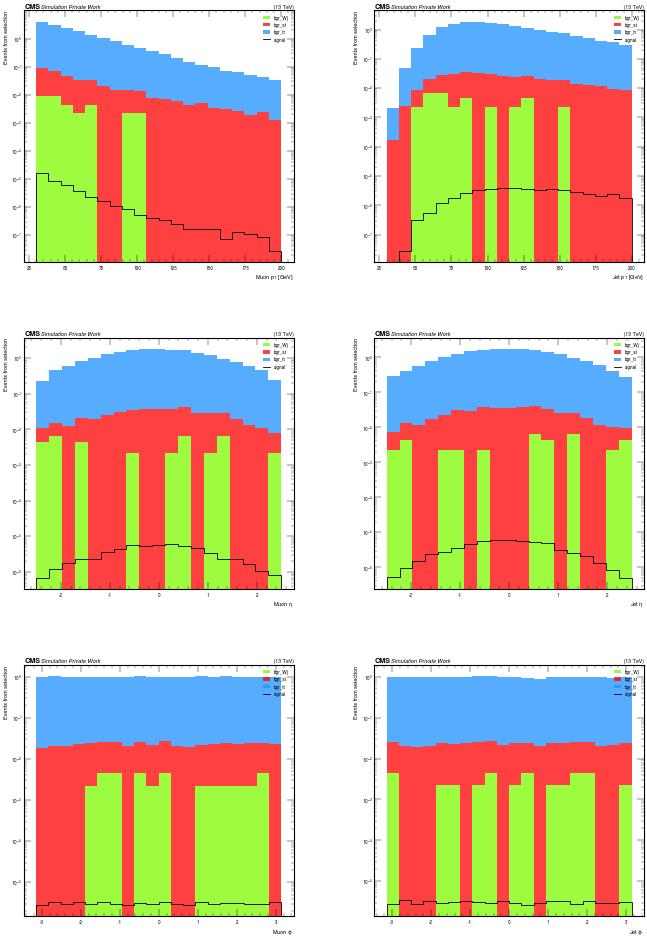

In [13]:
plotting(selection_hist, (3, 2), (20, 20*3/2), [0, 2, 4, 1, 3, 5], '')

We want so make a second series of histograms but rather than making sure that the different processes contribute to the plots according to their relative cross sections, all the histograms will be normalized. Additionally the histogram type is set to `step` instead of `stack`. This is to compare the processes with each other in close proximity where small differences and deviations from one another become a lot more apparent.

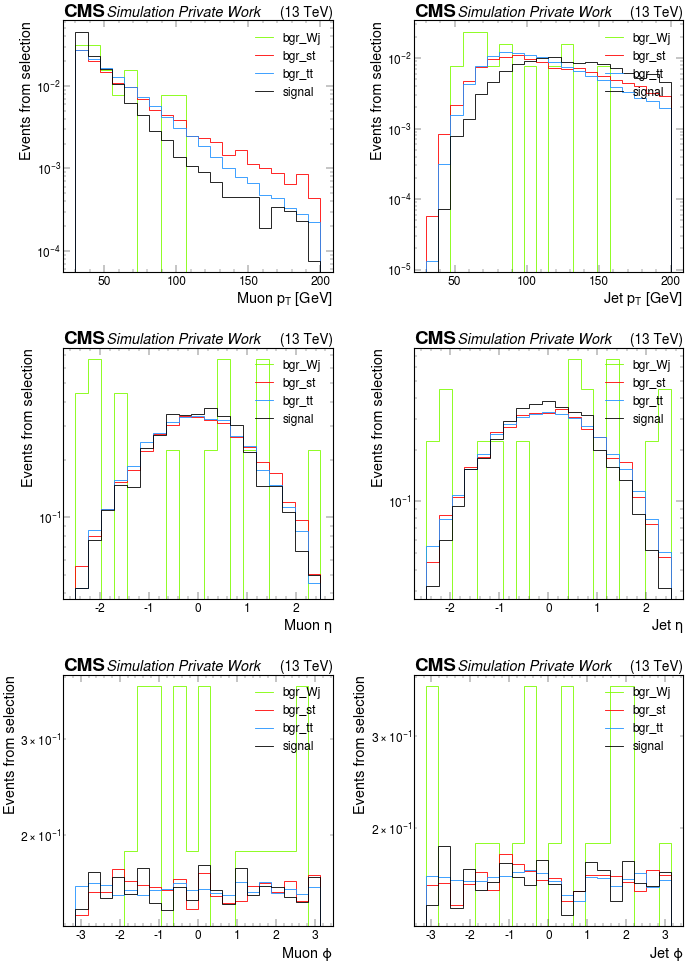

In [14]:
plotting(selection_hist, (3, 2), (20, 20*3/2), [0, 2, 4, 1, 3, 5], 'density')

The first time you run the two cells above after restarting the kernel, the title, axes and legend are shown super tiny. Just run the cells again and everything should be fine.

Looking at the various lines it immediately jumps out, that the green curves corresponding to the W + jets process do not appear to follow any of the other trends which are clearly visible for all the other processes with maybe the exception of the $p_T$ plots which are roughly following the exponential decrease of events with higher $p_T$. This behaviour is due to the fact that there are so few selected events coming from that process making the data extremely susceptible to statistical fluctions which overpower the trends expected from theory.      
Regarding the other processes their lines have similar progressions especially in the $\eta$ and $\phi$ plots which are virtually identical, though, slight differences can be identified in the $p_T$ plots. In the muon $p_T$ specifically the signal drops a little quicker than the two backgrounds. This behaviour is inverted for the leading jet $p_T$.

Judging by this insight, (more) useful observables for training can be chosen, eventhough physically all the information is already provided by $p_T$, $\eta$ and $\phi$. Since all the $\eta$ and $\phi$ lines featured a nearly identical shape, these observables by themselves are not all too helpful. There's not enough differentiating features present for a simple neural network to pick up on the nuances which in turn leads to poor(er) performance of the network. Instead, the angle between the objects $\Delta R$ can be used, since they are expected to be different due to different kinematics which naturally arise from the decay of a real Di-Higgs pair compared to e.g. the decay of a $t\bar{t}$ pair. In the same spirit it is beneficial to use the reconstructed invariant mass of the two $b$-jets, since only for the case of a Higgs decay should their reconstructed mass correspond to the Higgs mass. Similarly, the sum of all jet $p_T$ is also motivated by kinematic arguments.

## Preparing input vectors for the neural network

Neural networks take inputs in the form of "vectors", which can be implemented simply as numpy arrays. It is thus necessary to convert the awkward arrays used up until this point into numpy arrays. As a consequence the event data cannot be stored in the form of a dictionary anymore and must be ordered. The following shows the input vector structure used for the neural network:
- Muon $p_t$
- Muon $\eta$
- Muon $\phi$

- $b$-Jet 1 $p_t$
- $b$-Jet 1 $\eta$
- $b$-Jet 1 $\phi$
- $b$-Jet 1 $btag$
.    
.     
.    

- Jet N $p_t$
- Jet N $\eta$     
- Jet N $\phi$
- Jet N $btag$
- $m_{b \bar{b}}$
- $b$-Jet $\Delta R$
- $H_T$

Now, eventhough the angles $\eta$ and $\phi$ by themselves, as stated, are not of any great significance they are featured in the vector anyway for the sake of completion, though, they will not be used in training. 

For the neural network that we are going to use, the input vectors for all the events must have the same structure. Since the events have varying numbers of jets after the selection, they have to be adjusted such that all events feature the same number of events. This can be done in two ways:

1. Only 3 or 4 jets are used, since all events are required to feature them. Eventhough many jets would be cut using this method, only true event data would be used. Note that among the 3 or 4 jets used, the b-jets must be included as they are a necessary feature of the signature that is being searched for.

2. A greater number of jets are being used, since most events have more jets than 4. This method runs the risk that some events don't feature that many jets and the missing ones would have to be "introduced artificially" by adding e.g. zeroes to the vectors.

In the end the first method is used with only 3 jets, since only one or two jets are really relevant to the final states of the processes and further jets originate from soft gluon radiation.

Now, we want to calculate the new physical observables that we assume are better suited for training them being, as stated above, invariant $b$-jet pair mass $m_{b \bar{b}}$, the angle betwen the $b$-jets $\Delta R$ and the sum of all jet $p_{T}$ $H_{T}$. Starting off with the invariant $b$-jet pair mass $m_{b \bar{b}}$, this observable is motivated by the characteristic $b$-jet spectrum that follows from the decay of a heavy particle, the Higgs specifically:

### $(2) \,\,\, m_{b \bar{b}} = \sqrt{(p_{bj, 1} + p_{bj,2})^{2}}$

The spectrum is expected to show a resonance profile for the signal process with the peak positioned at the Higgs mass of 125 GeV. This is not true for the various background processes, since the two $b$-jets don't originate from one heavy particle. Calculating the invariant mass is easy to do. As 4-vector behavior is already embedded into the awkward arrays by hacing called `Momentum4D`, calculating the mass is as simple as adding the objects in question and calling `.mass`.     
Next up, the angle between the $b$-jets $\Delta R$. This observable is motivated by the difference in kinematics between the signal and background processes. In the case of the signal process both $b$-jets originate from the same Higgs, which, considering the Higgs moving in a certain direction, would lead the jets to be somewhat close by and to feature a smaller angle between each other compared to the background processes. For the background processes the angle is expected to be bigger:

### $(3) \,\,\, \Delta R = \sqrt{\Delta \eta^{2} + \Delta \phi^{2}}$

Once again the 4-vector behavior of the awkward arrays can be exploited to calculate the angle by calling `{jet1}.deltaR({jet2})`.       
And finally the sum of all jet $p_T$ $H_T$:

### $(4) \,\,\, \sum_{jets} p_{T, i}$

In the following cell the new observables are calculated.

In [15]:
# calculation of new observables
new_observables = {}

for process in selection_dict:
    
    btag_mask = (selection_dict[process].Jet.btagDeepB > btag_tight)
    
    sub_dict = {'m_bb': (selection_dict[process].Jet[btag_mask][:, 0] + selection_dict[process].Jet[btag_mask][:, 1]).mass,
                'deltaR': selection_dict[process].Jet[btag_mask][:, 0].deltaR(selection_dict[process].Jet[btag_mask][:, 1]),
                'ht': ak.sum(selection_dict[process].Jet[btag_mask][:, :], axis = 1).pt + selection_dict[process].Jet[~btag_mask].pt[:, 0]}
    
    new_observables[process] = sub_dict

In [16]:
# construct histogram for new observables
observables = (
    hist.Hist.new
    .StrCat(files_list, name = "process", label = "process")
    .Reg(30, 50, 500, name = "m_bb", label = "$b \\bar{b}$ " + "$m_{b \\bar{b}}$ [GeV]")
    .Reg(20, 0, 4, name = "deltaR", label = "$b \\bar{b}$ " + "$\\Delta R$")
    .Reg(20, 100, 300, name = "ht", label = "$b \\bar{b}$ " + "$H_T$")
    .Double()
) 

for process in files_list:

    # fill histogram with new observables
    observables.fill(
        process = process,
        m_bb = new_observables[process]['m_bb'],
        deltaR = new_observables[process]['deltaR'],
        ht = new_observables[process]['ht'],
        weight = weights[sub_cat],
    )

In [17]:
# construct sub histograms to be plotted 
new_observables_hist = {"m_bb":   observables[{"deltaR": sum, "ht": sum}],    # m_bb
                        "deltaR": observables[{"m_bb": sum, "ht": sum}],      # deltaR
                        "ht":     observables[{"m_bb": sum, "deltaR": sum}]}  # ht

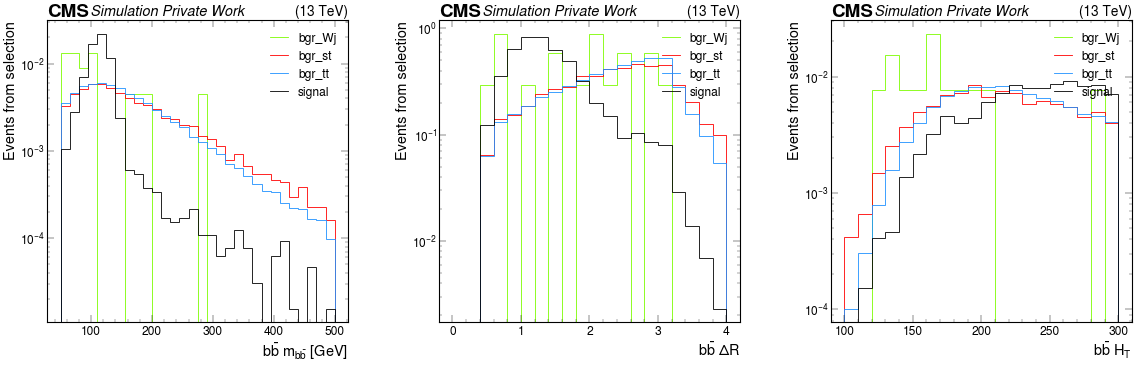

In [18]:
# plot new observables
plotting(new_observables_hist, (1, 3), (10*3.5, 10), [0, 1, 2], 'density')

In [19]:
# conversion of awkward arrays to numpy arrays
nn_input_ak = {}

for process in selection_dict:
    
    btag_mask = (selection_dict[process].Jet.btagDeepB > btag_tight)
    
    nn_input_ak[process] = ak.zip({
        "m_pt": selection_dict[process].Muon.pt[:, 0], 
        # "m_eta": selection_dict[process].Muon.eta[:, 0],
        # "m_phi": selection_dict[process].Muon.phi[:, 0],
        "j1_pt": selection_dict[process].Jet[btag_mask].pt[:, 0],
        # "j1_eta": selection_dict[process].Jet[btag_mask].eta[:, 0],
        # "j1_phi": selection_dict[process].Jet[btag_mask].phi[:, 0],
        "j1_btag": selection_dict[process].Jet[btag_mask].btagDeepB[:, 0],
        "j2_pt": selection_dict[process].Jet[btag_mask].pt[:, 1],
        # "j2_eta": selection_dict[process].Jet[btag_mask].eta[:, 1],
        # "j2_phi": selection_dict[process].Jet[btag_mask].phi[:, 1],
        "j2_btag": selection_dict[process].Jet[btag_mask].btagDeepB[:, 1],
        "j3_pt": selection_dict[process].Jet[~btag_mask].pt[:, 0],
        # "j3_eta": selection_dict[process].Jet[~btag_mask].eta[:, 0], 
        # "j3_phi": selection_dict[process].Jet[~btag_mask].phi[:, 0],
        "j3_btag": selection_dict[process].Jet[~btag_mask].btagDeepB[:, 0],
        "m_bb": new_observables[process]['m_bb'],
        "deltaR": new_observables[process]['deltaR'],
        "HT": new_observables[process]['ht'],
    })
    
nn_input = {k: ak.to_numpy(ak.Array(ak.unzip(nn_input_ak[k]))) for k in nn_input_ak.keys()}

In [20]:
print(nn_input['signal'][:, 0])
print(len(nn_input['signal'][0]))

[ 33.24768066 102.25         0.96630859  47.78125      0.99902344
 145.375        0.3840332  102.57808685   1.519472   295.40625   ]
4344


At the very end the input vectors for the neural network are saved in event specific files such that they can be opened in the next notebook where a neural network will finally be constructed and trained with the selected data.

In [21]:
# save data
for event_type in nn_input:
    np.savetxt('nn_input_' + event_type + '.txt', nn_input[event_type], delimiter=' ', newline='\n')

# BACKUP CELLS

In [22]:
# create a mask that cuts objects
def object_mask(obj, eta, pt):
    return (np.abs(obj.eta) < eta) & (obj.pt > pt)

# create mask that cuts events by requiring a certain number of lepton objects
def number_lep_mask(event, n):
    return (ak.num(event) == n)

# create mask that cuts events by requiring a certain number of jet objects
def number_jet_mask(event, n):
    return (ak.num(event) >= n)

# create mask that cuts events by requiring a certain number of b-jet objects
def number_btag_mask(event, b):
    return (ak.num(event[event.btagDeepB > btag_tight]) == b)